In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from definitions import model_save_dir
import os
from decision_transformer import DecisionTransformer
from utils import evaluate_on_env
from environments.mazes import AltTmaze, CuedTmaze

from definitions import model_save_dir, ROOT_FOLDER
import pickle
from torch.utils.data import DataLoader
from prepare_trajectory_data import TrajectoryDataset

model_fn = 'CuedTmazeTransformer_7_4_15.pt'

target = .95

env = CuedTmaze(render_mode='human')

# model hyperparameters
n_blocks = 1
embed_dim = 32
context_len = 10
n_heads = 4
dropout_p = 0.1
state_dim = env.n_states
act_dim = 4
batch_size = 1


# load model
model = DecisionTransformer(
    state_dim=state_dim,
    act_dim=act_dim,
    n_blocks=n_blocks,
    h_dim=embed_dim,
    context_len=context_len,
    n_heads=n_heads,
    drop_p=dropout_p,
)


model.load_state_dict(torch.load(os.path.join(model_save_dir, model_fn)))
model.eval()


DecisionTransformer(
  (transformer): Sequential(
    (0): Block(
      (attention): CausalMultiheadAttention(
        (q_net): Linear(in_features=32, out_features=32, bias=True)
        (k_net): Linear(in_features=32, out_features=32, bias=True)
        (v_net): Linear(in_features=32, out_features=32, bias=True)
        (proj_net): Linear(in_features=32, out_features=32, bias=True)
        (att_dropout): Dropout(p=0.1, inplace=False)
        (proj_dropout): Dropout(p=0.1, inplace=False)
      )
      (mlp): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=32, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (embed_ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (embed_timestep): Embedding(4096, 32)
  (emb

In [2]:
# load trajectories
traj_dir = os.path.join(ROOT_FOLDER, 'trajectories', 'CuedTmaze')

trajectories = pickle.load(open(os.path.join(traj_dir, 'cued_tmaze_trajectories.pkl'), 'rb'))
dataset = TrajectoryDataset(trajectories, context_len=context_len, rtg_scale=1.0)
traj_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)


In [3]:
data_iter = iter(traj_data_loader)

In [4]:
timesteps, states, actions, rtg, mask = next(data_iter)

timesteps = timesteps.type(torch.int32)  # B x T
states = states.type(torch.int)  # B x T x state_dim
actions = actions.type(torch.int32)  # B x T x act_dim
rtg = rtg.type(torch.float32).unsqueeze(-1)  # B x T x 1
traj_mask = mask.type(torch.int32)  # B x T


In [5]:
_, act_preds, _, weights = model.forward(timesteps, states, actions, rtg)

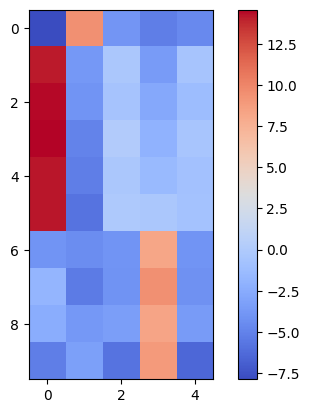

In [7]:
plt.imshow(act_preds.squeeze().detach(), cmap='coolwarm')
plt.colorbar()

In [8]:
action_target = torch.clone(actions).detach().to(torch.int64)  # B x T
state_target = torch.clone(states).detach().to(torch.int64)  # B x T x state_dim


In [9]:
def calculate_loss(predictions, targets, mask, loss_func, dim):
    predictions = predictions.view(-1, dim)[mask.view(-1) > 0].squeeze()
    targets = targets.view(-1)[mask.view(-1) > 0]
    loss = loss_func(predictions, targets)
    return loss

loss_func = torch.nn.CrossEntropyLoss()
# Now call it for each data set
action_loss = calculate_loss(act_preds, action_target, traj_mask, loss_func, act_dim+1)
action_loss

tensor(9.2267e-06, grad_fn=<NllLossBackward0>)

In [10]:
action_target

tensor([[1, 0, 0, 0, 0, 0, 3, 3, 3, 3]])

Now let's try to run it with only the first state as input

In [11]:
timesteps_ = torch.clone(timesteps) # B x T
states_ = torch.clone(states)  # B x T x state_dim
actions_ = torch.clone(actions)  # B x T x act_dim
rtg_ = torch.clone(rtg)  # B x T x 1

n_warmup_steps = 1
states_[:, n_warmup_steps:] = env.n_states
actions_[:, n_warmup_steps:] = env.n_actions
rtg_[:] = 0
rtg_[:n_warmup_steps] = .95

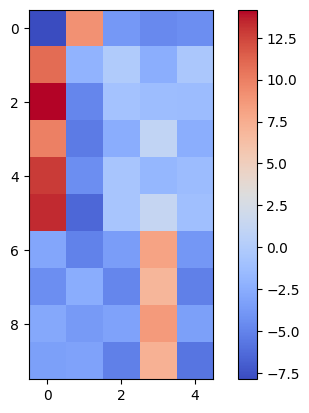

In [13]:
_, act_preds_, _, _ = model.forward(timesteps, states_, actions_, rtg_)

plt.imshow(act_preds_.squeeze().detach(), cmap='coolwarm')
plt.colorbar()


In [14]:
states_

tensor([[48, 54, 54, 54, 54, 54, 54, 54, 54, 54]], dtype=torch.int32)

In [15]:
env.n_actions

4

In [16]:
state_target

tensor([[48, 49, 40, 31, 22, 13,  4,  3,  2,  1]])

In [71]:
attention_weights = weights.squeeze().detach().numpy()
attention_weights

array([[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.08947146e-01, 1.91052809e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.89335483e-01, 6.03501558e-01, 7.16302358e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.35546713e-07, 7.66286121e-06, 2.30817287e-03, ...,
         1.30483731e-05, 0.00000000e+00, 0.00000000e+00],
        [6.66493666e-04, 5.68605913e-03, 2.17557345e-02, ...,
         2.74796411e-03, 1.98532902e-02, 0.00000000e+00],
        [1.19928754e-05, 2.36343229e-04, 1.15865888e-02, ...,
         2.78810156e-04, 8.05183500e-03, 5.37142914e-04]],

       [[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.36248493e-01, 7.63751507e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.37813407e-01, 

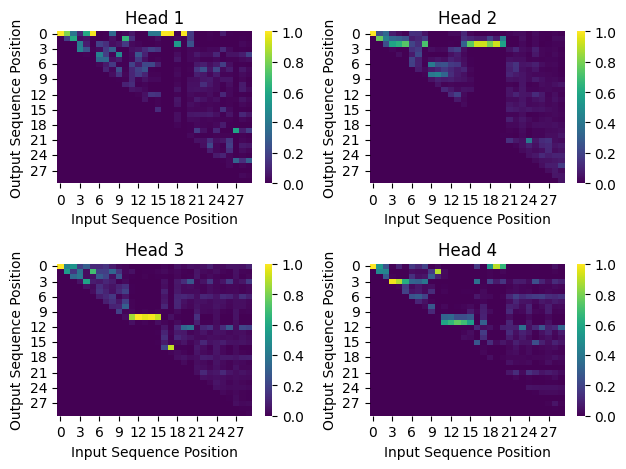

In [28]:
import seaborn as sns

# Assume `attention_weights` is a 2D NumPy array of shape [sequence_length, sequence_length],
# where sequence_length is the length of your input/output sequences.

fig, axes = plt.subplots(2,2)

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(attention_weights[i].T, cmap='viridis', ax=ax)
    ax.set_xlabel('Input Sequence Position')
    ax.set_ylabel('Output Sequence Position')
    ax.set_title('Head {}'.format(i+1))

plt.tight_layout()


<Axes: >

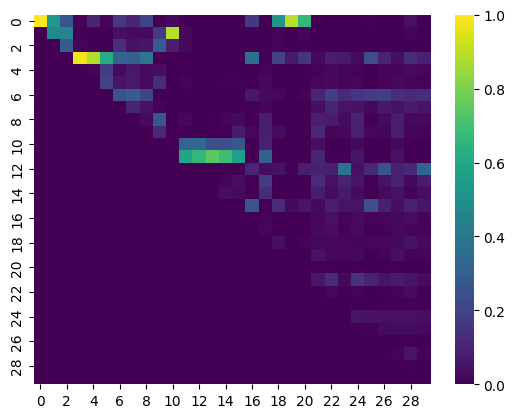

In [74]:
sns.heatmap(attention_weights[3].T, cmap='viridis')

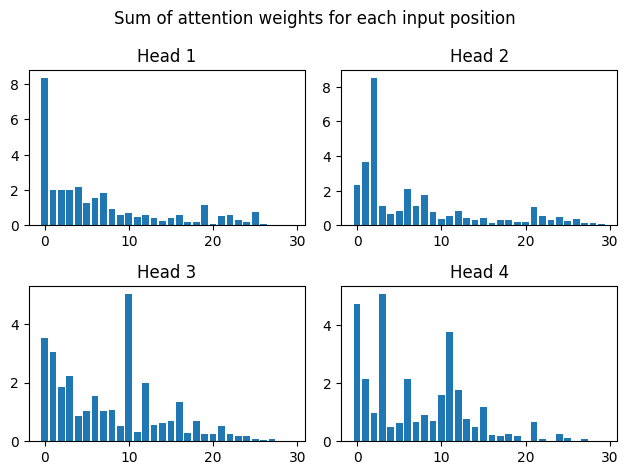

In [42]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()
for i, w in enumerate(attention_weights):
    ax[i].bar(range(w.shape[0]),w.sum(axis=0))
    ax[i].set_title(f'Head {i+1}')

plt.suptitle('Sum of attention weights for each input position')
plt.tight_layout()


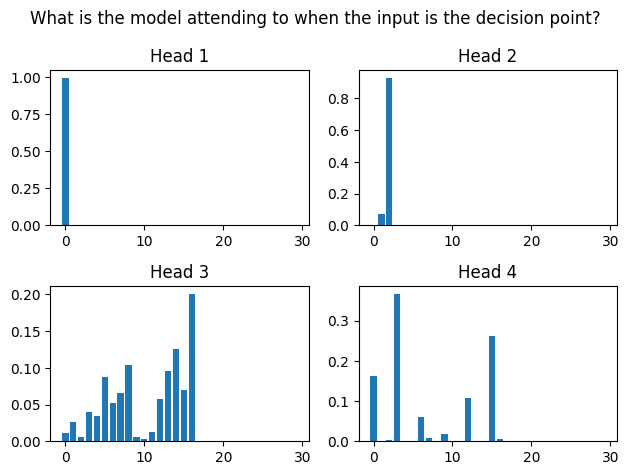

In [67]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()
for i, w in enumerate(attention_weights):
    ax[i].bar(range(w.shape[0]),w[16])
    ax[i].set_title(f'Head {i+1}')

plt.suptitle('What is the model attending to when the input is the decision point?')
plt.tight_layout()


In [72]:
states

tensor([[48, 49, 40, 31, 22, 13,  4,  3,  2,  1]], dtype=torch.int32)

In [73]:
actions

tensor([[1, 0, 0, 0, 0, 0, 3, 3, 3, 3]], dtype=torch.int32)